# Imports

In [1]:
import inspect
import logging
import os
import struct
import sys

import matplotlib as mpl
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import sklearn.metrics
import sklearn.model_selection

import torch
import torch.nn
import torch.optim
import torch.utils.data

from IPython.display import clear_output

# Parameters

In [2]:
dirname = "../datasets/MNIST_ORG"
test_x_basename = "t10k-images.idx3-ubyte"
test_y_basename = "t10k-labels.idx1-ubyte"
train_x_basename = "train-images.idx3-ubyte"
train_y_basename = "train-labels.idx1-ubyte"

# Function Definitions

In [3]:
def read_labels(filename):
    with open(filename, "rb") as fp:
        magic, size = struct.unpack(">II", fp.read(8))
        if magic != 2049:
            raise RuntimeError(f"Magic number mismatch, expected 2049, got {magic}")
        data = fp.read()
        return np.frombuffer(data, dtype=np.uint8).astype(int)

In [4]:
def read_images(filename):
    with open(filename, "rb") as fp:
        magic, size, rows, cols = struct.unpack(">IIII", fp.read(16))
        if magic != 2051:
            raise RuntimeError(f"Magic number mismatch, expected 2049, got {magic}")
        data = fp.read()
        return np.frombuffer(data, dtype=np.uint8).reshape((-1,28,28)).astype(float)

# Data Loading

In [5]:
training_images = read_images( os.path.join(dirname, train_x_basename) )
training_labels = read_labels( os.path.join(dirname, train_y_basename) )
validation_images = read_images( os.path.join(dirname, test_x_basename) )
validation_labels = read_labels( os.path.join(dirname, test_y_basename) )

print(f"training_images:   {str(training_images.dtype) : >8} {training_images.shape}")
print(f"training_labels:   {str(training_labels.dtype) : >8} {training_labels.shape}")
print(f"validation_images: {str(validation_images.dtype) : >8} {validation_images.shape}")
print(f"validation_labels: {str(validation_labels.dtype) : >8} {validation_labels.shape}")

training_images:    float64 (60000, 28, 28)
training_labels:      int64 (60000,)
validation_images:  float64 (10000, 28, 28)
validation_labels:    int64 (10000,)


# Data Preprocessing

In [6]:
training_images = training_images / 255.
# training_labels = training_labels.reshape(-1,1)
validation_images = validation_images / 255.
# validation_labels = validation_labels.reshape(-1,1)

## Data Visualization

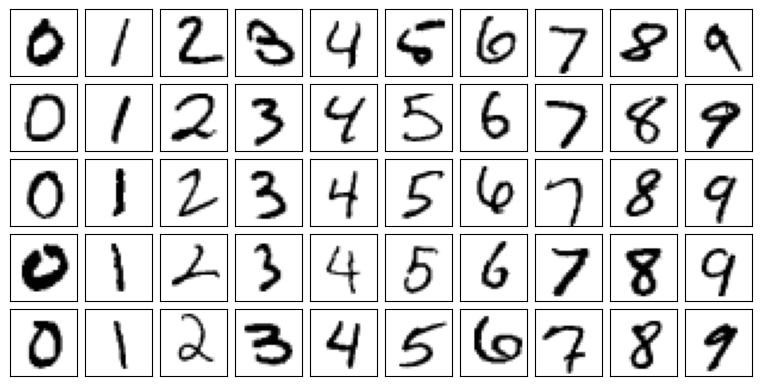

In [7]:
n_rows = 5
n_cols = 10

fig = plt.figure(constrained_layout=True, figsize=(0.75*n_cols,0.75*n_rows))
gs = mpl.gridspec.GridSpec(
    nrows=n_rows,
    ncols=n_cols,
    figure=fig
)
for col in range(10):
    samples = validation_images[validation_labels == col]
    for row in range(n_rows):
        ax = fig.add_subplot(gs[row,col])
        ax.imshow(samples[row], cmap="binary", vmin=0., vmax=1.)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
plt.show()

# ANN

In [8]:
class ANN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Flatten(start_dim=1, end_dim=-1),
            torch.nn.Linear(in_features=28*28, out_features=128),
            torch.nn.LeakyReLU(inplace=True),
            torch.nn.Linear(in_features=128, out_features=64),
            torch.nn.LeakyReLU(inplace=True),
            torch.nn.Linear(in_features=64, out_features=10),
            # torch.nn.Softmax(dim=1)
        )

    def forward(self, X):
        return self.model(X)

# Callback Handlers

## CalculateLoss

In [9]:
class CalculateLoss():
    def __init__(
        self,
        loss_fn,
        training_dataloader=None,
        validation_dataloader=None,
        device="cpu",
        warm_start=False
    ):
        super().__init__()
        args, _, _, values = inspect.getargvalues(inspect.currentframe())
        values.pop("self")
        for arg, val in values.items():
            setattr(self, arg, val)
        self.training_loss = list()
        self.validation_loss = list()
        self.mini_batch_loss = list()

    @torch.no_grad()
    def _get_performance(self, model, dataloader):
        loss, n_samples = torch.tensor(0.).to(self.device), 0
        targets, predictions = list(), list()
        model = model.to(self.device).eval()
        for x_train,y_train in dataloader:
            n_samples += len(x_train)
            x_train, y_train = x_train.to(self.device), y_train.to(self.device)
            y_pred = model(x_train)
            loss += loss_fn(y_pred, y_train)
            targets.extend( y_train.detach().to("cpu").numpy() )
            predictions.extend( y_pred.detach().to("cpu").numpy().argmax(axis=1) )
        loss /= n_samples
        targets, predictions = np.asarray(targets), np.asarray(predictions)
        accuracy = 100. * np.sum(targets == predictions) / len(targets)
        return loss.item(), accuracy

    def _calculate_training_performance(self, model):
        loss, accuracy = self._get_performance(model,self.training_dataloader)
        self.training_loss.append(loss)
        self.training_accuracy.append(accuracy)

    def _calculate_validation_performance(self, model):
        loss, accuracy = self._get_performance(model,self.validation_dataloader)
        self.validation_loss.append(loss)
        self.validation_accuracy.append(accuracy)

    def _calculate_performance(self, model, logs):
        if self.training_dataloader is not None:
            self._calculate_training_performance(model)
            logs["training_loss"] = np.asarray(self.training_loss)
            logs["training_accuracy"] = np.asarray(self.training_accuracy)
        if self.validation_dataloader is not None:
            self._calculate_validation_performance(model)
            logs["validation_loss"] = np.asarray(self.validation_loss)
            logs["validation_accuracy"] = np.asarray(self.validation_accuracy)

    def on_training_start(self, n_epochs, model, logs):
        if not self.warm_start:
            self.training_loss = list()
            self.validation_loss = list()
            self.training_accuracy = list()
            self.validation_accuracy = list()
            self.mini_batch_loss = list()
        self._calculate_performance(model, logs)

    def on_mini_batch_end(self, epoch, mini_batch, n_batches, batch_size, loss, model, logs):
        while len(self.mini_batch_loss) < epoch:
            self.mini_batch_loss.append(list())
        self.mini_batch_loss[-1].append(loss)
        logs["mini_batch_loss"] = np.asarray(self.mini_batch_loss[-1])

    def on_epoch_end(self, epoch, model, logs):
        self._calculate_performance(model, logs)

## PrintProgress

In [10]:
# 1 final score
# 2 every 10th score
# 3 every 10th score + mini batch summary
# 4 every 10th score + mini batch mini details
# 5 every 10th score + mini batch all details
# 6 every score
# 7 every score + mini batch summary
# 8 every score + mini batch mini details
# 9 every score + mini batch all details

class PrintProgress():
    def __init__(self, verbose=0, verbose_epoch_mod=10, verbose_mini_batch_mod=10):
        super().__init__()
        args, _, _, values = inspect.getargvalues(inspect.currentframe())
        values.pop("self")
        for arg, val in values.items():
            setattr(self, arg, val)
        self.logger = logging.getLogger("PrintProgress")
        if not self.logger.hasHandlers():
            self.logger.addHandler( logging.StreamHandler(sys.stdout) )
        self.logger.setLevel(logging.DEBUG-verbose)

    def _log_epoch_progress_helper(self, epoch, n_epochs, logs, message_level):
        n_epochs_digits = int(np.log10(n_epochs)) + 1
        # training performance
        training_loss = logs.get("training_loss", [np.nan])[-1]
        training_accuracy = logs.get("training_accuracy", [np.nan])[-1]
        # validation performance
        validation_loss = logs.get("validation_loss", [np.nan])[-1]
        validation_accuracy = logs.get("validation_accuracy", [np.nan])[-1]
        # message
        message = (
            f"Epoch: {epoch:>{n_epochs_digits}d}/{n_epochs} ({epoch/n_epochs*100:6.2f}%)   "
            f"Training Loss: {training_loss:.6f}   Validation Loss: {validation_loss:.6f}   "
            f"Training Accuracy: {training_accuracy:6.2f}   Validation Accuracy: {validation_accuracy:6.2f}"
        )
        self.logger.log(level=logging.DEBUG-message_level, msg=message)

    def _log_epoch_progress(self, epoch, n_epochs, logs):
        if epoch == n_epochs:
            message_level = 1
        elif epoch == 0 or epoch % self.verbose_epoch_mod == 0:
            message_level = 2
        else:
            message_level = 6
        self._log_epoch_progress_helper(epoch, n_epochs, logs, message_level)

    def _log_mini_batch_progress_helper(self, epoch, n_epochs, mini_batch, n_batches, batch_size, loss, message_level):
        n_epochs_digits = int(np.log10(n_epochs)) + 1
        n_mini_batch_digits = int(np.log10(n_batches)) + 1
        message = (
            f"Epoch: {epoch:<{n_epochs_digits}d}  "
            f"[{mini_batch:>{n_mini_batch_digits}d}/{n_batches}  ({mini_batch/n_batches*100:3.0f}%)]   "
            f"Loss: {loss:15.6f}"
        )
        self.logger.log(level=logging.DEBUG-message_level, msg=message)

    def _log_mini_batch_summary(self, epoch, n_epochs, logs, message_level):
        mini_batch_loss = logs["mini_batch_loss"]
        mean, std = np.mean(mini_batch_loss), np.std(mini_batch_loss)
        n_epochs_digits = int(np.log10(n_epochs)) + 1
        message = (
            f"Epoch: {epoch:<{n_epochs_digits}d}   "
            f"Mini Batch Average Loss: {mean:.6f} +/- {std:.6f}"
        )
        self.logger.log(level=logging.DEBUG-message_level, msg=message)

    def _log_mini_batch_progress(self, epoch, n_epochs, mini_batch, n_batches, batch_size, loss, logs):
        if epoch == n_epochs or epoch % self.verbose_epoch_mod == 0:
            message_level = 4 if mini_batch % self.verbose_mini_batch_mod == 0 or mini_batch == n_batches else 5
            if self.verbose >= 6:
                message_level += 4
        elif mini_batch % self.verbose_mini_batch_mod == 0 or mini_batch == n_batches:
            message_level = 8
        else:
            message_level = 9
        self._log_mini_batch_progress_helper(epoch, n_epochs, mini_batch, n_batches, batch_size, loss, message_level)
        if mini_batch == n_batches:
            if epoch % self.verbose_epoch_mod == 0 or epoch == n_epochs:
                message_level = 3
            else:
                message_level = 7
            self._log_mini_batch_summary(epoch, n_epochs, logs, message_level)

    def on_training_start(self, n_epochs, model, logs):
        self.n_epochs = n_epochs
        self._log_epoch_progress(0, self.n_epochs, logs)

    def on_mini_batch_end(self, epoch, mini_batch, n_batches, batch_size, loss, model, logs):
        self._log_mini_batch_progress(epoch, self.n_epochs, mini_batch, n_batches, batch_size, loss, logs)

    def on_epoch_end(self, epoch, model, logs):
        self._log_epoch_progress(epoch, self.n_epochs, logs)

## PlotProgress

In [11]:
class PlotProgress():
    def __init__(self, plotting_samples, plotting_targets, limit_loss, device):
        super().__init__()
        args, _, _, values = inspect.getargvalues(inspect.currentframe())
        values.pop("self")
        for arg, val in values.items():
            setattr(self, arg, val)

    def _plot_loss(self, ax, training_loss, validation_loss, limit):
        epochs = None
        if training_loss is not None:
            epochs = np.arange(len(training_loss))
            ax.plot(epochs[-limit:], training_loss[-limit:], label="Traning Loss")
        if validation_loss is not None:
            epochs = epochs if epochs is not None else np.arange(len(validation_loss))
            ax.plot(epochs[-limit:], validation_loss[-limit:], label="Validation Loss")
        if epochs is not None:
            ax.set_xlabel("Epoch")
            ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
            ax.set_ylabel("Cross Entropy Loss")
            ax.legend()

    def _plot_accuracy(self, ax, training_accuracy, validation_accuracy, limit):
        epochs = None
        if training_accuracy is not None:
            epochs = np.arange(len(training_accuracy))
            ax.plot(epochs[-limit:], training_accuracy[-limit:], label="Traning Accuracy")
        if validation_accuracy is not None:
            epochs = epochs if epochs is not None else np.arange(len(validation_accuracy))
            ax.plot(epochs[-limit:], validation_accuracy[-limit:], label="Validation Accuracy")
        if epochs is not None:
            ax.set_xlabel("Epoch")
            ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
            ax.set_ylabel("Accuracy")
            ax.legend()
    
    def _plot_samples(self, fig, gs, samples, targets, predictions):
        for ii,(sample,y_true,y_pred) in enumerate(zip(samples,targets,predictions)):
            color = "Greens" if y_pred == y_true else "Reds"
            ax = fig.add_subplot(gs[ii])
            ax.imshow(sample, cmap=color, vmin=0., vmax=1.)
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            if y_pred != y_true:
                ax.set_title(y_pred)

    def _get_grid_size(self, count):
        n_cols = 13
        n_rows = int(np.ceil(count/n_cols))
        return n_rows, n_cols

    @torch.no_grad()
    def _plot_results(self, epoch, training_loss, validation_loss, training_accuracy, validation_accuracy, model):
        if epoch % 10 == 0:
            model = model.to(self.device).eval()
            outputs = model(
                torch.from_numpy(self.plotting_samples.astype(np.float32)).to(self.device)
            ).detach().to("cpu").numpy()

            clear_output(wait=True)
            n_rows, n_cols = 4, 2
            gs = mpl.gridspec.GridSpec(n_rows, n_cols)
            fig = plt.figure(figsize=(n_cols*6.4, n_rows*4.8))
            self._plot_loss(fig.add_subplot(gs[0,0]), training_loss, validation_loss, -1)
            self._plot_loss(fig.add_subplot(gs[0,1]), training_loss, validation_loss, self.limit_loss)
            self._plot_accuracy(fig.add_subplot(gs[1,0]), training_accuracy, validation_accuracy, -1)
            self._plot_accuracy(fig.add_subplot(gs[1,1]), training_accuracy, validation_accuracy, self.limit_loss)
            self._plot_samples(
                fig, gs[2:,:].subgridspec(*self._get_grid_size(len(self.plotting_samples))),
                self.plotting_samples,
                self.plotting_targets,
                outputs.argmax(axis=1)
            )
            fig.suptitle(f"Iteration {epoch}", x=(fig.subplotpars.right + fig.subplotpars.left)/2, y=1.001)
            fig.tight_layout()
            plt.show()

    def on_training_start(self, n_epochs, model, logs):
        self._plot_results(
            0,
            logs.get("training_loss", None),
            logs.get("validation_loss", None),
            logs.get("training_accuracy", None),
            logs.get("validation_accuracy", None),
            model
        )

    def on_mini_batch_end(self, epoch, mini_batch, n_batches, batch_size, loss, model, logs):
        return

    def on_epoch_end(self, epoch, model, logs):
        self._plot_results(
            epoch,
            logs.get("training_loss", None),
            logs.get("validation_loss", None),
            logs.get("training_accuracy", None),
            logs.get("validation_accuracy", None),
            model
        )

# Traning

## Parameters

In [12]:
n_epochs = 50
batch_size = 256
shuffle = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ann = ANN()

print(device)
print(ann)

cpu
ANN(
  (model): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): LeakyReLU(negative_slope=0.01, inplace=True)
    (5): Linear(in_features=64, out_features=10, bias=True)
  )
)


## Loss Function

In [13]:
loss_fn = torch.nn.CrossEntropyLoss(reduction="mean")

## Optimizer

In [14]:
optimizer = torch.optim.Adam(ann.parameters())

## Data Loaders

### Training Data

In [15]:
training_dataset = torch.utils.data.TensorDataset(
    torch.from_numpy(training_images.astype(np.float32)),
    torch.from_numpy(training_labels)
)
training_dataloader = torch.utils.data.DataLoader(
    training_dataset,
    batch_size=batch_size,
    shuffle=shuffle,
)

### Validation Data

In [16]:
validation_dataset = torch.utils.data.TensorDataset(
    torch.from_numpy(validation_images.astype(np.float32)),
    torch.from_numpy(validation_labels)
)
validation_dataloader = torch.utils.data.DataLoader(
    validation_dataset,
    batch_size=batch_size,
    shuffle=False
)

## Initialize Callbacks

In [17]:
calculate_loss = CalculateLoss(
    loss_fn=torch.nn.CrossEntropyLoss(reduction="sum"),
    training_dataloader=torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(
            torch.from_numpy(training_images[:batch_size].astype(np.float32)),
            torch.from_numpy(training_labels[:batch_size])
        )
    ),
    validation_dataloader=torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(
            torch.from_numpy(validation_images[:batch_size].astype(np.float32)),
            torch.from_numpy(validation_labels[:batch_size])
        )
    ),
    device=device
)

print_progress = PrintProgress(
    verbose=6
)

n_samples = 13
plotting_samples = np.concatenate([
    validation_images[validation_labels == ii][:n_samples]
    for ii in range(10)
])
plotting_targets = np.concatenate([
    [ii] * n_samples
    for ii in range(10)
])
plot_progress = PlotProgress(
    plotting_samples=plotting_samples,
    plotting_targets=plotting_targets,
    limit_loss=10,
    device=device
)

callbacks = [calculate_loss, print_progress, plot_progress]

## Training Loop

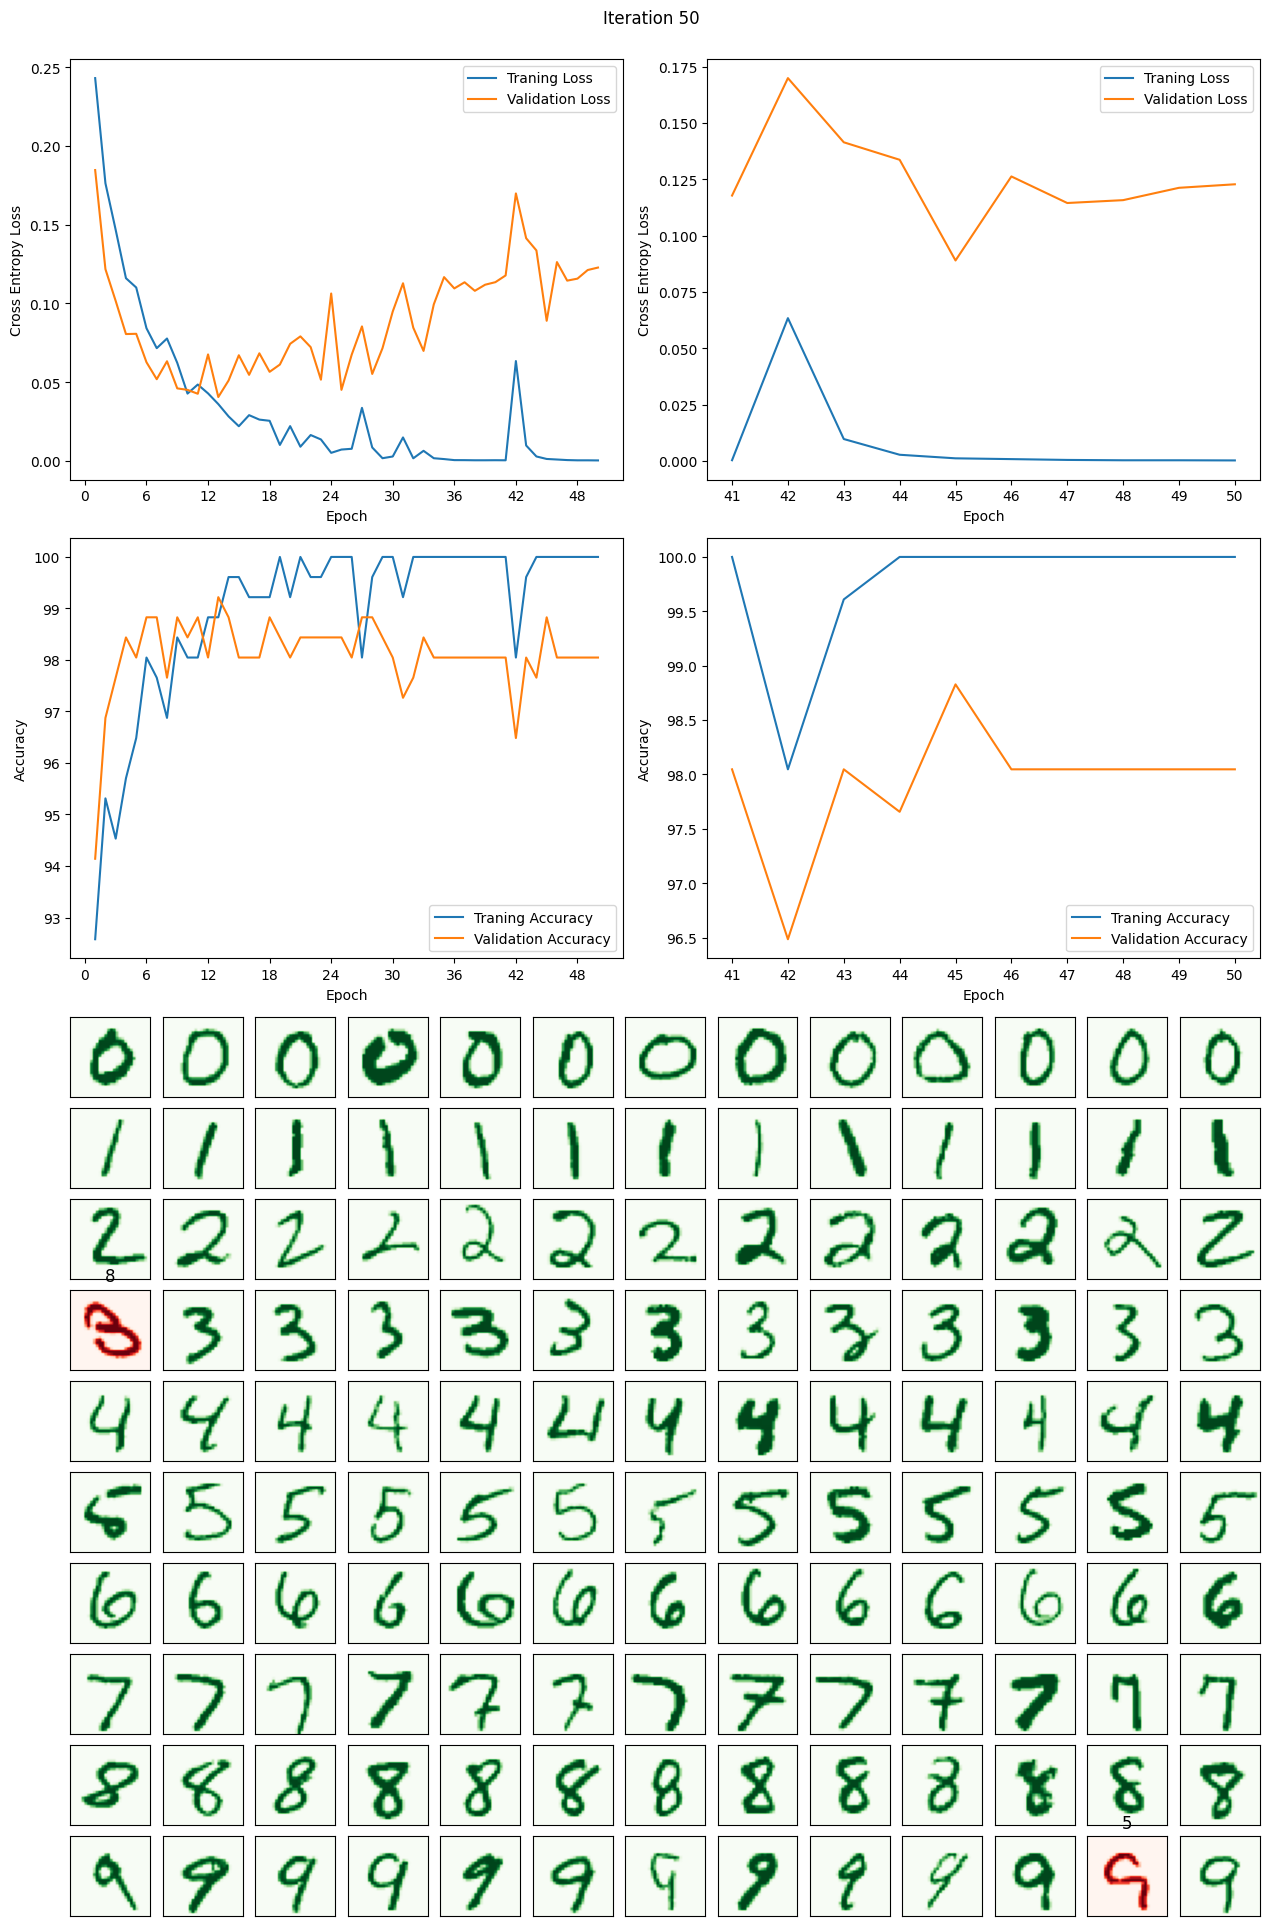

In [18]:
logs = dict()

# notify each callback of the beginning of training
ann = ann.to(device).eval()
for callback in callbacks:
    callback.on_training_start(n_epochs, ann, logs)

for epoch in range(1,n_epochs+1):
    for mini_batch,(x_train,y_train) in enumerate(training_dataloader, 1):
        ann = ann.to(device).train()
        x_train, y_train = x_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        y_pred = ann(x_train)
        loss = loss_fn(y_pred, y_train)
        loss.backward()
        optimizer.step()

        # notify each callback of the mini batch
        ann = ann.to(device).eval()
        for callback in callbacks:
            callback.on_mini_batch_end(epoch, mini_batch, len(training_dataloader), len(x_train), loss.item(), ann, logs)
    
    # notify each callback of the end of epoch
    ann = ann.to(device).eval()
    for callback in callbacks:
        callback.on_epoch_end(epoch, ann, logs)

# Confusion Matrix

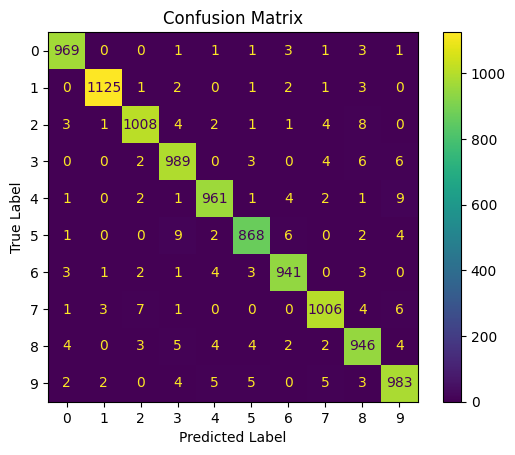

In [38]:
targets, predictions = list(), list()
with torch.no_grad():
    ann = ann.to(device).eval()
    for x_train,y_train in validation_dataloader:
        x_train, y_train = x_train.to(device), y_train.to(device)
        y_pred = ann(x_train)
        targets.extend( y_train.detach().to("cpu").numpy() )
        predictions.extend( y_pred.detach().to("cpu").numpy().argmax(axis=1) )
targets, predictions = np.asarray(targets), np.asarray(predictions)

confusion_matrix = sklearn.metrics.ConfusionMatrixDisplay(
    confusion_matrix=sklearn.metrics.confusion_matrix(targets, predictions),
    display_labels=np.arange(10),
)
confusion_matrix.plot()
confusion_matrix.ax_.set_title("Confusion Matrix")
confusion_matrix.ax_.set_xlabel("Predicted Label")
confusion_matrix.ax_.set_ylabel("True Label")
plt.show()